In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import sklearn
import math, random
import torch
import torchaudio
from torchaudio import transforms
import pandas as pd
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data import random_split
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import init
import os
import cmath
import scipy
from torch.autograd import Variable
import tqdm
import wandb
import pyroomacoustics as pyrm
from timeit import default_timer as timer

In [22]:
class InputFeature():
    
    @staticmethod
    def load_audio(audio_file):
        """
        audio_file: path to the wav file
        """
        signal, sr = torchaudio.load(audio_file)
        return signal,sr
    
    
    @staticmethod
    def getLPS_firstchannel(loaded_audio,i,sr=None):
        """
        loaded_audio: raw audio input
        sr: sampling rate
        return: log power spectrum of the first channel which is our reference mic
        """
        power_spec = torch.stft(loaded_audio[i,:],n_fft=512,return_complex=True)+1e-8
        lps = torch.abs(power_spec)**2
        s = torchaudio.transforms.AmplitudeToDB()(lps)
        return s,sr
    
    @staticmethod
    def getFullLPS(loaded_audio):
        """Gets the full lps of the audio not just the first channel as described in the paper"""
        power_spec = torch.stft(loaded_audio,n_fft=512,return_complex=True)+1e-8
        lps = torch.abs(power_spec)**2
        s = torchaudio.transforms.AmplitudeToDB()(lps)
        return s

    @staticmethod
    def getSpatialFeature(audio):
        """
        Calculates the ipd
        audio: loaded mixed audio
        
        """
        all_ipds = np.ones(InputFeature.getLogPowerSpectrum(audio)[0].shape)

        ipd_13 = InputFeature.calcIPD(audio,0,2)
        ipd_15 = InputFeature.calcIPD(audio,0,4)
        ipd_35 = InputFeature.calcIPD(audio,2,4)

        return np.concatenate([ipd_13,ipd_15,ipd_35])
        
    
    @staticmethod
    def getLogPowerSpectrum(audio):
        """
        audio: loaded audio in its raw wave form
        channel_num: the microphone channel for which we want to get the mic
        retuns the audio in t-f domain by taking the stft
        """
        power_spec = torch.stft(audio,n_fft=512,return_complex=True)+1e-8 #,win_length=32,hop_length=16

        return power_spec
    
    @staticmethod
    def getMeanNorm(np_arr):
        norm = (np_arr - np.mean(np_arr))/ (np.max(np_arr) - np.min(np_arr) )
        return norm
    
    
    @staticmethod
    def calcIPD(audio,i1,i2):
        """Calculates the ipd between pairs of microphones, helper function used in getSpatialFeature method"""
        #calc ipd
        individual_ipd = np.angle(InputFeature.getLogPowerSpectrum(audio)[i1]/InputFeature.getLogPowerSpectrum(audio)[i2])
        ipd_norm = individual_ipd/np.mean(individual_ipd)+1e-8
        ipd_norm=np.rad2deg(ipd_norm)
        
#         #mask
#         spectral_feature = InputFeature.getFullLPS(audio)
#         sp_ = spectral_feature[i1,:]
#         ipd_norm[sp_ < 2] = 0 #play around with masking threshold
        
        return ipd_norm
    
        
        
    @staticmethod
    def getSv(angle,fs):
        """
        Calculates the steering vector
        angle: target azimuth angle
        """
        frequency_bin  = np.arange(0, 1 + 512 / 2) * fs / 512
        all_sv = []
        phi = [0.005,0.005,0.01] 
        c = 343 #m/s speed of sound
        w = 2 *math.pi* frequency_bin #angular freq
        all_sv.append(np.ones(len(frequency_bin))) #since refeerence mic is mic 1

        for i in range(1,len(phi)):
            t = phi[i]/c
            sv = np.exp(-1j*i*w*t*np.cos(np.deg2rad(angle))).real
            all_sv.append(sv)
        return np.array(all_sv)
    
    @staticmethod
    def getAngleFeature(ipds, sv):
        """
            For just 3 channels
            ipds: list of ipds from getIPD_withoutt_angle
            steeringvecs: list of steering vecs from getSV for all the speaker/noise
            num_channels: with CI we use 6 microphone channel or 2
            num_speaker: how many speaker source are in the audio mix
            Note: the first steering vector belongs to the target speaker
            return: Angle feature of target speaker (for 3 mics)

        """
        print(f"ipd shape is {ipds.shape} and svs shape is {len(sv)}")
        ipd = ipds.reshape(3,257,ipds.shape[1]) #i reshape to 9,257 because we have 9 microphone pairings from the 6 CI microphones
        target_AF = 0

        afs = []
        for i in range(ipd.shape[0]):
            af = ((sv[i] * ipd[i,:].T)) /(np.abs(sv[i] * ipd[i,:].T))
            af = np.nan_to_num(af)
            afs.append(af.T)
            target_AF+=af
            
            #we need to try the angle feature with just the (3,5) or just (1,3)

        return target_AF.T,afs

    @staticmethod
    def delaySumBeamformer(fs,M):
        """
        WORKING
        target_angle: azimuth of the target speaker
        M: number of microphones
        fs: sampling rate of the brir/rir/hrtf
        returns: delay-sum beamformer filter for all the angle we consider and the target beamformer is at the lat position in the list
        
        """
        # we can define the angles we want to design a beamformer filter for, in the paper the did 36 filter so i guess 36 angles 
        #and the last angle p was the angle of the target speaker.
        
        direction_grid = list(range(0,360,10))
        all_filters = []
        for angle in direction_grid:
            sv = InputFeature.getSv(angle,fs)
            f = sv/M
            all_filters.append(f)
        return all_filters
    
    @staticmethod
    def delaySumBeamformer_Directivity(fs,M,target_angle):
        """
        Calculates the beam directivity pattern and not just the beam weights like above
        """
        # we can define the angles we want to design a beamformer filter for, in the paper the did 36 filter so i guess 36 angles 
        #and the last angle p was the angle of the target speaker.
        
        direction_grid = list(range(0,360,10))
        all_filters = []
        beam_directivity =[]
        target_beam = InputFeature.getSv(target_angle,fs)/M
        for angle in direction_grid:
            sv = InputFeature.getSv(angle,fs)
            f = sv/M
            directivity = target_beam.conj().T @ f
            all_filters.append(directivity)
        return np.array(all_filters)    
    
    @staticmethod
    def help_dpr(w_h,mixed_input):
        """helper function to multiply the beamformer weights with the mixed audio"""
        all_= []
        for i in range(w_h.shape[0]):
            t = (w_h[i]**2) * (mixed_input[i,:].numpy().T**2)
            all_.append(t.T) #so we have shape freq,time
        return np.concatenate(all_)

    @staticmethod
    def help_dpr_test(w_h,mixed_input):
        """
        helper function to multiply the beamformer directivity pattern with the mixed audio
        It is different from helper_dpr in that the dimension of the beam directivity isnt the same as the beam weights
        """
        all_= []

        for i in range(mixed_input.shape[0]):
            t = (w_h**2) @ (mixed_input[i,:].numpy()**2)
            sum_t = t.sum(axis=1)
            all_.append(t) #so we have shape freq,time
        return np.concatenate(all_)

    @staticmethod
    def DPR_test(beamformer,audio,target_azimuth):
        """
        beamformer: the filters gotten from delaySumBeamformer_directivty
        audio: aduio mixture that is passed to the model in raw
        Just testing the effect of using beam directivy instead of weights in the formula
        """

        #get audio in t-f domain

        all_ =[]

        mixed_input = InputFeature.getLogPowerSpectrum(audio)
        
        #what direction is target azimuth is to determine which channels to focus on because of the big head in between
        pos_ipd = [1,3,5]
        mixed_input = mixed_input[pos_ipd] #this takes the 3 channesls on one ear
        
        direction_grid = list(range(0,360,10))
        bin_index = np.digitize(target_azimuth,direction_grid,right=True) #select the direction grid the target azimuth falls into

        #get the numerator
        w_h_target = np.array(beamformer[bin_index]).conj() #get the conjugal transformed filter for the target azimuths
        
        top = InputFeature.help_dpr(w_h_target,mixed_input)
        
        #get the denominator
        bottom =0 
        beam_directivity = InputFeature.delaySumBeamformer_Directivity(sr,3,target_azimuth)

        for i in range(len(beam_directivity)):
            w_h = np.array(beam_directivity[i]).conj()
            f = InputFeature.help_dpr_test(w_h,mixed_input)
            bottom +=f 

        dpr = top.real  / bottom.real
        dpr = dpr

        #mask_dpr
#         dpr=np.rad2deg(dpr)
#         spectral_feature = InputFeature.getFullLPS(audio)
#         spectral_feature = spectral_feature[pos_ipd] #this only takes 1,3,5
#         spectral_feature = spectral_feature.reshape(spectral_feature.shape[0]*spectral_feature.shape[1],spectral_feature.shape[2])       

#         dpr[spectral_feature < 2] = 0
        
        return dpr, (top.real,bottom.real)
    
    @staticmethod
    def DPR(beamformer,audio,target_azimuth):
        """
        beamformer: the filters gotten from delaySumBeamformer
        audio: aduio mixture that is passed to the model in raw
        """

        #get audio in t-f domain

        all_ =[]

        mixed_input = InputFeature.getLogPowerSpectrum(audio)
        
        #what direction is target azimuth is to determine which channels to focus on because of the big head in between
        pos_ipd = [1,3,5]
        mixed_input = mixed_input[pos_ipd] #this takes the 3 channesls on one ear
        
        direction_grid = list(range(0,360,10))
        bin_index = np.digitize(target_azimuth,direction_grid,right=True) #select the direction grid the target azimuth falls into
        
        #get the numerator
        w_h_target = np.array(beamformer[bin_index]).conj() #get the conjugal transformed filter for the target azimuths

        top = InputFeature.help_dpr(w_h_target,mixed_input)
        #get the denominator
        bottom =0 
        beam_directivity = InputFeature.delaySumBeamformer_Directivity(sr,3,target_azimuth)
        
        for i in range(len(beamformer)):
            w_h = np.array(beamformer[i]).conj()
            f = InputFeature.help_dpr(w_h,mixed_input)
            bottom +=f

        dpr = top.real  / bottom.real
#         print(dpr.shape)
        dpr = dpr.real
        

        print(f"dpr shape is {dpr.shape}")
        #mask_dpr
#         dpr=np.rad2deg(dpr)
#         spectral_feature = InputFeature.getFullLPS(audio)
#         spectral_feature = spectral_feature[pos_ipd] #this only takes 1,3,5
#         spectral_feature = spectral_feature.reshape(spectral_feature.shape[0]*spectral_feature.shape[1],spectral_feature.shape[2])       

#         dpr[spectral_feature < 2] = 0
        
        return dpr, (top.real,bottom.real)

            
    @staticmethod
    def DSNR(beamformer,audio,target_azimuth):
        """Calculates the dsnr based on formula in paper"""
        all_ =[]

        mixed_input = InputFeature.getLogPowerSpectrum(audio)

        
        pos_ipd = [1,3,5]
        mixed_input = mixed_input[pos_ipd] #this takes the 3 channesls on one ear

        direction_grid = list(range(0,360,10))
        bin_index = np.digitize(target_azimuth,direction_grid,right=True) #select the direction grid the target azimuth falls into

        #get the numerator
        w_h_target = np.array(beamformer[bin_index]).conj() #get the conjugal transformed filter for the target azimuths
        top = InputFeature.help_dpr(w_h_target,mixed_input)

        #get the strongest interference
        #get the beam pattern for the angle before(bin_index-1 and bin_index +1)  our target speaker and the angle after out target..then we do the multiplication and the max
        strong_interf = 0
        bottom = 0

        if bin_index==0:
            #if the targets az is in the first bin then the strongest interference should be the next bin
            strong_interf = bin_index +1
            w_h_interf = np.array(beamformer[strong_interf]).conj()
            bottom = InputFeature.help_dpr(w_h_interf,mixed_input)
        elif bin_index==35: #last index
            #if the targets az is in the las bin then the strongest interference should be the previous bin
            strong_interf = bin_index -1
            w_h_interf = np.array(beamformer[strong_interf]).conj()
            bottom = InputFeature.help_dpr(w_h_interf,mixed_input)
        else:
            #if the targets az is in the other bin then the strongest interference could be the next or previous bin, so i'll just pick the previous bin
            strong_interf = bin_index-1
            w_h_interf = np.array(beamformer[strong_interf]).conj()
            bottom = InputFeature.help_dpr(w_h_interf,mixed_input)

#             print(f"bottom shape is {bottom.shape}")

        dsnr = (top + 1e-8) / (bottom+1e-8)
        dsnr = dsnr.real
        #mask dpr with spectral
        spectral_feature = InputFeature.getFullLPS(audio)
        spectral_feature = spectral_feature[pos_ipd] #this only takes 1,3,5
        spectral_feature = spectral_feature.reshape(spectral_feature.shape[0]*spectral_feature.shape[1],spectral_feature.shape[2])       
        dsnr = np.rad2deg(dsnr) 
        dsnr[spectral_feature < 2] = 0
        return dsnr
   

  
   
    

# TEST CODE FOR ALL THE METHODS

In [16]:

audio,sr = InputFeature.load_audio("/Users/u618151/Desktop/Work/Datasets/Speech/Libre-speech/Test_cliping/mixed_3.wav")
audio_t,sr = InputFeature.load_audio("/Users/u618151/Desktop/Work/Datasets/Speech/Libre-speech/Test_cliping/target_3.wav")

spectral,sr = InputFeature.getLPS_firstchannel(audio,0)
s =  InputFeature.getFullLPS(audio)
spatial = InputFeature.getSpatialFeature(audio)

sr=22050
sv = InputFeature.getSv(300,sr)

AF,afs = InputFeature.getAngleFeature(spatial, sv) 

# sr = 22050

beam = InputFeature.delaySumBeamformer(sr,M=3)
dpr,tb = InputFeature.DPR_test(beam,audio,300)
y = InputFeature.DSNR(beam,audio,300)



ipd shape is (771, 869) and svs shape is 3


# PLOTS

In [25]:
def mask(audio,to_be_masked, threshold,indx):

    pos_ipd = [1,3,5]
#     to_be_masked=np.rad2deg(to_be_masked)
    spectral_feature = InputFeature.getFullLPS(audio)
    spectral_feature = spectral_feature[pos_ipd] #this only takes 1,3,5
    spectral_feature = spectral_feature[indx,:] #spectral_feature.reshape(spectral_feature.shape[0]*spectral_feature.shape[1],spectral_feature.shape[2])       

    to_be_masked[spectral_feature < threshold] = 0

    return to_be_masked

def mask_dpr(audio,to_be_masked, threshold):
        
    pos_ipd = [1,3,5]
#     to_be_masked=np.rad2deg(to_be_masked)
    spectral_feature = InputFeature.getFullLPS(audio)
    spectral_feature = spectral_feature[pos_ipd] #this only takes 1,3,5
    spectral_feature = spectral_feature.reshape(spectral_feature.shape[0]*spectral_feature.shape[1],spectral_feature.shape[2])       

    to_be_masked[spectral_feature < threshold] = 0
        
    return to_be_masked
                            
def getPlots_AFs(target_path,interf_path,mixed_path,snr,az_list):
    
    audio_t, fs = InputFeature.load_audio(target_path)
    audio_i, fs = InputFeature.load_audio(interf_path)
    audio_m, fs = InputFeature.load_audio(mixed_path)
    sr = 22050
    
    #spatial: IPD
    ipd_target = InputFeature.getSpatialFeature(audio_t)
    ipd_i = InputFeature.getSpatialFeature(audio_i)
    ipd_mixed = InputFeature.getSpatialFeature(audio_m)


    fs =22050
    #spectral

    spect_m = InputFeature.getFullLPS(audio_m)
    pos_ipd = [1,3,5]
    spect_m = spect_m[pos_ipd]
    
    spect_t = InputFeature.getFullLPS(audio_t)
    spect_t = spect_t[pos_ipd]
    
    spect_i = InputFeature.getFullLPS(audio_i)
    spect_i = spect_i[pos_ipd]
    
    
    fig5, axs5 = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15,3))
    fig5.subplots_adjust(top=0.8)
    fig5.suptitle('Spectrogram',y=0.98)
    
    img_m_s_1 = librosa.display.specshow(spect_t[0,:].numpy(), y_axis='linear', x_axis = 'time',cmap=cm.jet, vmin=0,vmax=20,ax=axs5[0])
    axs5[0].set(title='target')
    axs5[0].label_outer()
    axs5[0].label_outer()
    axs5[0].set_ylim([0,8000])
    
    img_m_s_2 = librosa.display.specshow(spect_i[0,:].numpy(), y_axis='linear', x_axis = 'time',cmap=cm.jet,vmin=0,vmax=20,ax=axs5[1])
    axs5[1].set(title='Noise')
    axs5[1].label_outer()
    axs5[1].label_outer()
    axs5[1].set_ylim([0,8000])    
    
    img_m_s_3 = librosa.display.specshow(spect_m[0,:].numpy(), y_axis='linear', x_axis = 'time',cmap=cm.jet,vmin=0,vmax=20,ax=axs5[2])
    axs5[2].set(title='Mixed')
    axs5[2].label_outer()
    axs5[2].label_outer()
    axs5[2].set_ylim([0,8000])  
    
    fig5.colorbar(img_m_s_3, ax=axs5)   
    
       #IPDS

#     ipd_13 = mask(audio_m,ipd_mixed[:257], 2,0)
#     ipd_15 = mask(audio_m,ipd_mixed[257:514], 2,1)
#     ipd_35 = mask(audio_m,ipd_mixed[514:], 2,2)
    
 
    
# #     ipd_13 = ipd_mixed[:257]
# #     ipd_15 = ipd_mixed[257:514]
# #     ipd_35 = ipd_mixed[514:]
        
    
    
#     fig5, axs5 = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15,3))
#     fig5.subplots_adjust(top=0.8)
#     fig5.suptitle('IPDs',y=0.98)
    
#     img_m_i_1 = librosa.display.specshow(ipd_13, y_axis='linear', x_axis = 'time',cmap=cm.jet,vmin=0, vmax =20, ax=axs5[0])
#     axs5[0].set(title='IPD @ ch (1,3)')
#     axs5[0].label_outer()
#     axs5[0].label_outer()
#     axs5[0].set_ylim([0,8000])
    
#     img_m_i_2 = librosa.display.specshow(ipd_15, y_axis='linear', x_axis = 'time',vmin=0, vmax =8,cmap=cm.jet,ax=axs5[1])
#     axs5[1].set(title='IPD @ ch (1,5)')
#     axs5[1].label_outer()
#     axs5[1].label_outer()
#     axs5[1].set_ylim([0,8000])    
    
#     img_m_i_3 = librosa.display.specshow(ipd_35, y_axis='linear', x_axis = 'time',vmin=0, vmax =20,cmap=cm.jet,ax=axs5[2])
#     axs5[2].set(title='IPD @ ch (3,5)')
#     axs5[2].label_outer()
#     axs5[2].label_outer()
#     axs5[2].set_ylim([0,8000])  
    
#     fig5.colorbar(img_m_i_3, ax=axs5) 
    
    
    
#     mixed af
#     sv_m = InputFeature.getSv(az_list[0],fs)
    
#     AF_m,afs_m = InputFeature.getAngleFeature(ipd_mixed, sv_m)

#     afs_m_1 = mask(audio_m,afs_m[0], 2,0)
#     afs_m_2 = mask(audio_m,afs_m[1], 2,1)
#     afs_m_3 = mask(audio_m,afs_m[2], 2,2)
#     AF_m = mask(audio_m,AF_m, 2,0)

        
#     fig5, axs5 = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(15,3))
#     fig5.subplots_adjust(top=0.8)
#     fig5.suptitle('Angle Feature mixed',y=0.98)
    
#     img_m_1 = librosa.display.specshow(afs_m_1, y_axis='linear', x_axis = 'time',cmap=cm.jet,vmin=-2, vmax =5, ax=axs5[0])
#     axs5[0].set(title='AF @ ch (1,3)')
#     axs5[0].label_outer()
#     axs5[0].label_outer()
#     axs5[0].set_ylim([0,8000])
    
#     img_m_3 = librosa.display.specshow(afs_m_2, y_axis='linear', x_axis = 'time',vmin=-2, vmax =5,cmap=cm.jet,ax=axs5[1])
#     axs5[1].set(title='AF @ ch (1,5)')
#     axs5[1].label_outer()
#     axs5[1].label_outer()
#     axs5[1].set_ylim([0,8000])    
    
#     img_m_4 = librosa.display.specshow(afs_m_3, y_axis='linear', x_axis = 'time',vmin=-2, vmax =5,cmap=cm.jet,ax=axs5[2])
#     axs5[2].set(title='AF @ ch (3,5)')
#     axs5[2].label_outer()
#     axs5[2].label_outer()
#     axs5[2].set_ylim([0,8000])
    
    
#     img_m_5 = librosa.display.specshow(AF_m, y_axis='linear', x_axis = 'time',vmin=-2, vmax =5,cmap=cm.jet,ax=axs5[3])
#     axs5[3].set(title='AF summed up')
#     axs5[3].label_outer()
#     axs5[3].label_outer()
#     axs5[3].set_ylim([0,8000])   
    
#     fig5.colorbar(img_m_5, ax=axs5) 
    
    
    #DPR With bottom as directivity
    dpr_m,tb_m = InputFeature.DPR_test(beam,audio_m,az_list[0])
    top_m = tb_m[0]
    bottom_m = tb_m[1]
    
#     dpr_m = mask_dpr(audio_m,dpr_m, 2)
#     top_m = mask_dpr(audio_t,top_m, 2)
#     bottom_m = mask_dpr(audio_t,bottom_m, 2)

        
    fig5, axs5 = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15,3))
    fig5.subplots_adjust(top=0.8)
    fig5.suptitle('DPR Mixed with directivity',y=0.98)
    
    img_m_1 = librosa.display.specshow(top_m[:257], y_axis='linear', x_axis = 'time',cmap=cm.jet, vmin=0, vmax =8,ax=axs5[0])
    axs5[0].set(title='Top')
    axs5[0].label_outer()
    axs5[0].label_outer()
    axs5[0].set_ylim([0,8000])
    fig5.colorbar(img_m_1, ax=axs5[0])
    
    img_m_3 = librosa.display.specshow(bottom_m[:257], y_axis='linear', x_axis = 'time',vmin=0, vmax =2,cmap=cm.jet,ax=axs5[1])
    axs5[1].set(title='Bottom')
    axs5[1].label_outer()
    axs5[1].label_outer()
    axs5[1].set_ylim([0,8000])   
    fig5.colorbar(img_m_3, ax=axs5[1]) 
    
    img_m_4 = librosa.display.specshow(dpr_m[:257], y_axis='linear', x_axis = 'time',vmin=0, vmax =10,cmap=cm.jet,ax=axs5[2])
    axs5[2].set(title='DPR')
    axs5[2].label_outer()
    axs5[2].label_outer()
    axs5[2].set_ylim([0,8000])
    
    fig5.colorbar(img_m_4, ax=axs5[2])
    
    #mixed af
    dpr_m2,tb_m2 = InputFeature.DPR(beam,audio_m,az_list[0])
    top_m2 = tb_m2[0]
    bottom_m2 = tb_m2[1]
    
#     top_m2= mask_dpr(audio_m,top_m2, 2)
#     bottom_m2 = mask_dpr(audio_m,bottom_m2, 2)
        
    fig5, axs5 = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15,3))
    fig5.subplots_adjust(top=0.8)
    fig5.suptitle('DPR Mixed without beam directivity',y=0.98)
    
    img_m_1 = librosa.display.specshow(top_m2[:257], y_axis='linear', x_axis = 'time',cmap=cm.jet,vmin=0, vmax =8, ax=axs5[0])
    axs5[0].set(title='Top')
    axs5[0].label_outer()
    axs5[0].label_outer()
    axs5[0].set_ylim([0,8000])
    fig5.colorbar(img_m_1, ax=axs5[0]) 
    
    img_m_3 = librosa.display.specshow(bottom_m2[:257], y_axis='linear', x_axis = 'time',cmap=cm.jet,vmin=0, vmax =8,ax=axs5[1])
    axs5[1].set(title='Bottom')
    axs5[1].label_outer()
    axs5[1].label_outer()
    axs5[1].set_ylim([0,8000]) 
    fig5.colorbar(img_m_3, ax=axs5[1]) 
    
    img_m_4 = librosa.display.specshow(dpr_m2[:257], y_axis='linear', x_axis = 'time',vmin=0, vmax =8,cmap=cm.jet,ax=axs5[2])
    axs5[2].set(title='DPR')
    axs5[2].label_outer()
    axs5[2].label_outer()
    axs5[2].set_ylim([0,8000])
    
    fig5.colorbar(img_m_4, ax=axs5[2])     
    
    return (dpr_m,top_m,bottom_m,dpr_m2,top_m2,bottom_m2)
    
    
    
    
    
    

dpr shape is (771, 869)


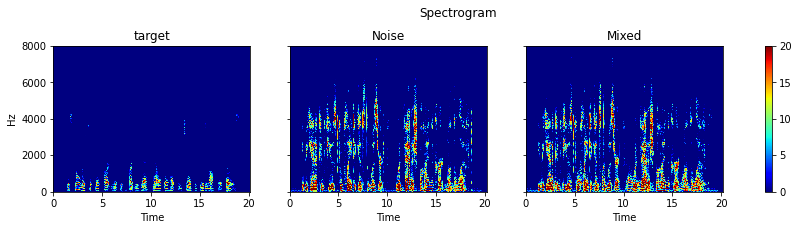

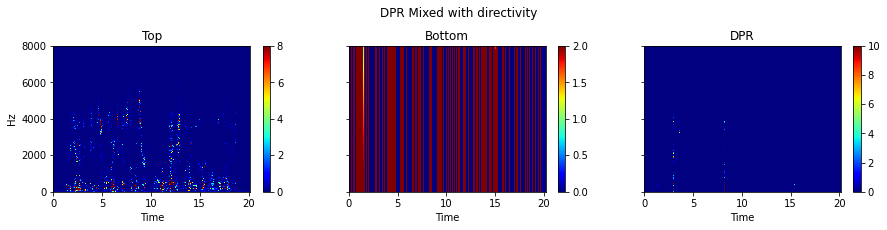

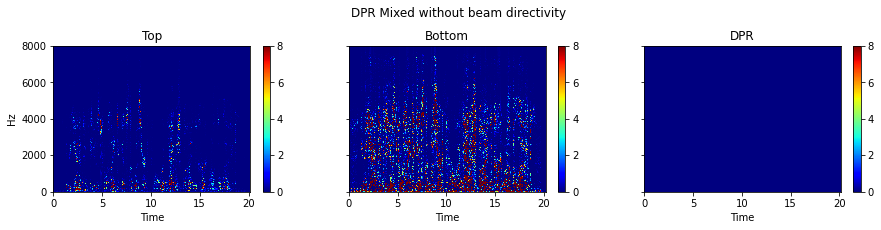

In [26]:
mixed_path = "sounds/mixed_3.wav"
target_path = "sounds/target_3.wav"
interf_path ="sounds/interf_3.wav"


snr = 5
azimuth_angles = [300,75]

dpr_m,top_m,bottom_m,dpr_m2,top_m2,bottom_m2 = getPlots_AFs(target_path,interf_path,mixed_path,snr,azimuth_angles)